# WYS API - Investigate NULLs

This notebook investigates the rows with NULL speed and count columns.
as in issue https://github.com/CityofToronto/bdit_data-sources/issues/393   

**Summary**  
- there are currently `872` rows in `wys.raw_data`  
```
SELECT DISTINCT (api_id)
FROM wys.raw_data;
```

- `727` of these contain rows with NULL speed and count columns  
```
SELECT DISTINCT (api_id)
FROM wys.qc_raw_data_nulls;
```

In [1]:
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd 
import configparser
from psycopg2 import connect
import psycopg2.sql as pg
import pandas.io.sql as pandasql
import numpy as np 
import datetime
import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager
import matplotlib.dates as mdates
from matplotlib.lines import Line2D # for legend

In [2]:
import geopandas as gpd
import shapely
from shapely.geometry import Point, Polygon

In [3]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Config

In [4]:
# JUPYTERHUB
CONFIG=configparser.ConfigParser()
CONFIG.read('/home/cnangini/db.cfg')
dbset=CONFIG['DBSETTINGS']
con=connect(**dbset)
i=0

# Definitions

# Plotting Functions

In [5]:
# for mulitliple line chart

import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '/home/cnangini/PROJECTS/bdit_data-sources/wys/api/lib/')

import linechart_fns

In [6]:
# Base settings for line chart
# sett_grp['data'].pop(2)
mode='Vehicles'
sett_base = {
    'lw': 3,'fontsize': 14,
    # Axes labels, limits, and grids
    'ylab': 'Daily Volume (' + mode + ')', 'xlab': 'Day',
    'major_loc': {'loc': mdates.DayLocator(),'fmt': mdates.DateFormatter('%d %b %Y')},
    'minor_loc': mdates.DayLocator(interval=1),  # every other day
    'major_grid_on': True,
    'major_grid': {
        'gridax': 'y', 'linewidth': 0.5, 'stroke':'#d3d3d3'
    },
    # legend
    'legend_label': True, 'legend_pos': 'lower left','legend_ncol': 4,
    'data': {
         0: {
            'lc': 'k', 'ls': 'solid',
            'leg': 'line 1'
            }
    },
    'shaded': {
        # Weekends
        0: {'lims':[[]], 'c': '#ccffff', 'alpha': 0.9 },
        # Lockdown2
        1: {'lims':[[pd.Timestamp('2020-06-22'), pd.Timestamp('2020-06-29')]],
            'c': '#CCBB44', #'zorder':-100,
            'alpha': 0.6,
            'label': {
                'x': pd.Timestamp('2020-06-22') + datetime.timedelta(days=1),
                'y': 39000, 'text': 'Lockdown 2',
                'fontsize': 12, 'colour': 'k', 'rotation': 0}},
        # Skeleton for installation area
        2: {'lims':[[]],
            'c': 'gray',
            'alpha': 0.7,
            'label': {
                'x': 999, # dummy placeholder value
                'y': 999, # dummy placeholder value
                'text': 'Installation',
                'fontsize': 12, 
                'colour': 'k', 
                'rotation': 0}},
    }
}

# Query Database

In [7]:
def get_nulls():
    '''Get NULL signs.
    
    '''
    
    query="""
        SELECT *      
        FROM wys.qc_raw_data_nulls
    """

    with con:
        df = pandasql.read_sql(query, con)
        
    return df

In [8]:
def get_null_geoms():
    '''Get coordinates of NULL signs.
    
    '''
    
    query="""
        SELECT api_id, lat, lon        
        FROM wys.qc_raw_data_nulls_geom
    """

    with con:
        df_geo = pandasql.read_sql(query, con)
        
    return df_geo

In [8]:
# df_geo=get_null_geoms()

# print(df_geo.shape)
# df_geo.head()

(395, 3)


In [10]:
df_geo.head()

,api_id,lat,lon
0,1750,43.792496,-79.350678
1,1967,43.655830,-79.454555
2,2786,43.684964,-79.536916
3,2787,43.687118,-79.538962
4,2788,43.712468,-79.328337


In [9]:
# df=get_nulls()

# print(df.shape)
# df.head()

(161960, 4)


,api_id,dt,hour,num_null
0,1750,2021-03-30,0,6
1,1750,2021-03-30,1,7
2,1750,2021-03-30,2,10
3,1750,2021-03-30,3,9
4,1750,2021-03-30,4,9


In [12]:
saveflag=False
filename='df_nulls.csv'

if saveflag:
    fname=filename
    df.to_csv(fname, index=False)
else:
    df=pd.read_csv(filename)

# I Analysis

## I.1 NULLS per hour

In [31]:
cutoff = 5

In [32]:
# Sum of number of null rows per hour, for all rows where num_null > cutoff, over all api_ids

df.loc[df['num_null']>cutoff, ['hour', 'num_null']].groupby(['hour']).sum()

,num_null
hour,
0,55144
1,74189
2,85045
3,94138
4,92895
5,66114
6,38891
7,20025
8,10709


In [33]:
df_grp=df.loc[df['num_null']>cutoff, ['hour', 'num_null']].groupby(['hour']).sum()
print(list(df_grp))
print(df_grp.index)

['num_null']
Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23],
           dtype='int64', name='hour')


Text(0, 0.5, 'Total number of null rows/hr')

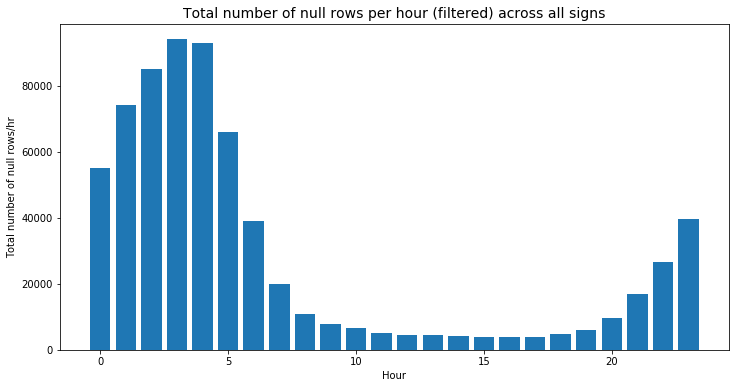

In [36]:
fig, ax =plt.subplots(1)
fig.set_size_inches(12, 6)
ax = plt.gca()

plt.bar(df_grp.index.values, df_grp['num_null'].values, width=0.8, bottom=None, align='center')
    
# fig.text(0.5, 0.07, 'Percent change COVID - BASELINE (%)', ha='center',size=fsize)
# fig.text(0.08, 0.5, 'Count', va='center', rotation='vertical', size=fsize)

ax.set_title('Total number of null rows per hour (filtered) across all signs', fontsize=14)
ax.set_xlabel('Hour')
ax.set_ylabel('Total number of null rows/hr')

## I.2 NULL dates
Find dates for each sign where for at least one hour per day there were more than `cutoff=5` NULL rows.  

In [48]:
df_daily=df.loc[df['num_null']>cutoff, ['api_id', 'dt', 'num_null']].groupby(['api_id','dt']).sum().reset_index()
print(list(df_daily))

['api_id', 'dt', 'num_null']


In [49]:
df_daily.head()

,api_id,dt,num_null
0,1750,2021-03-30,48
1,1750,2021-03-31,55
2,1750,2021-04-01,36
3,1750,2021-04-02,40
4,1750,2021-04-03,52


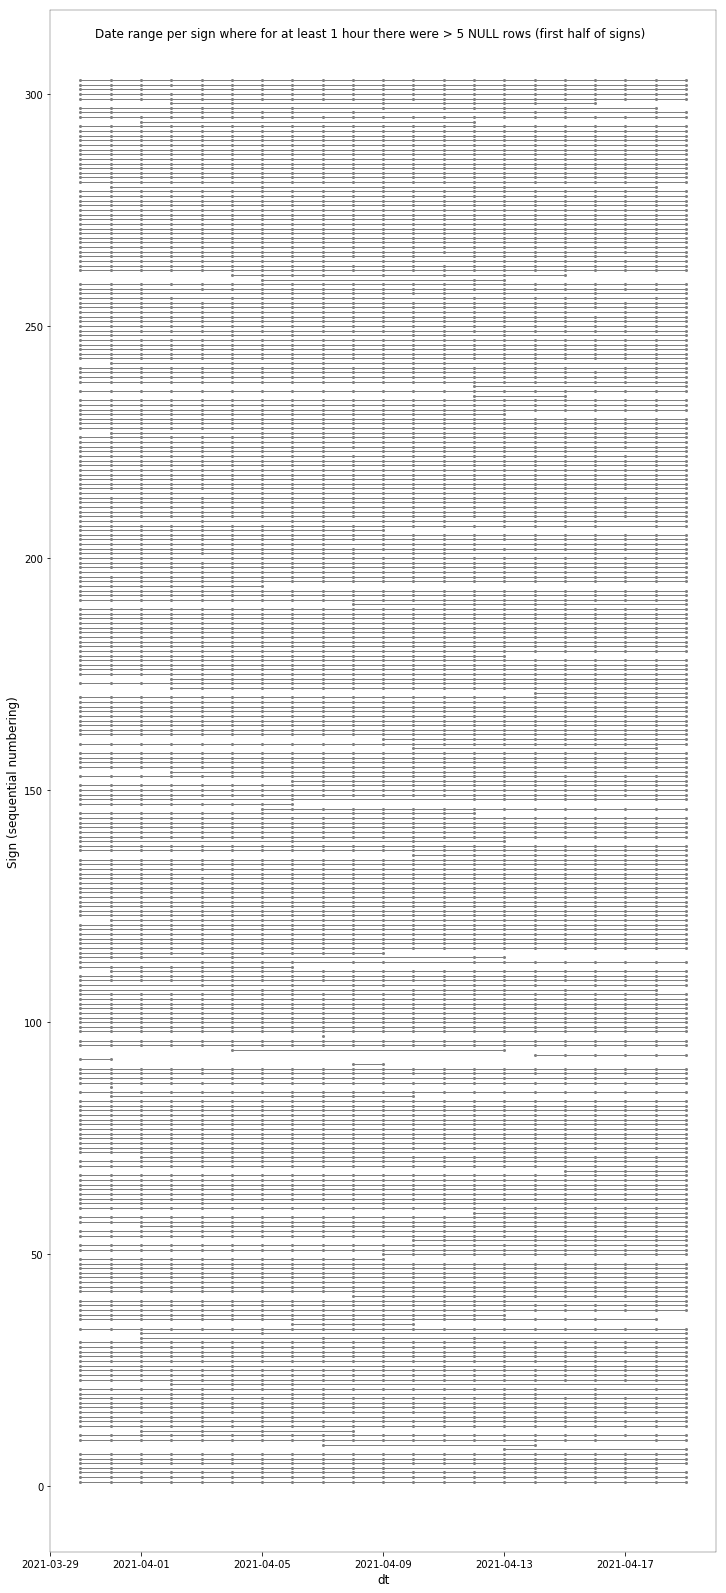

In [176]:
# Plot dates for each sign satifsying condition of at least one hour/day with > cutoff=5 NULL rows
# First half of all signs

fig, ax =plt.subplots(1)
fig.set_size_inches(10, 22)
ax = plt.gca()

num_api=len(df_daily['api_id'].unique())

idx=1
for this_id in df_daily['api_id'].unique()[:int(num_api/2)]:
    ypos=idx
    idx+=1
    ax.plot(df_daily.loc[df_daily['api_id']==this_id, ['dt']], 
            df_daily.loc[df_daily['api_id']==this_id, ['api_id']].apply(lambda x: x*0+ypos), 
            linewidth=1, color='gray', marker='o', markersize=2)

fig.suptitle('Date range per sign where for at least 1 hour there were > 5 NULL rows (first half of signs)', fontsize=12)
fig.tight_layout()

ax.set_ylabel('Sign (sequential numbering)', fontsize=12)
ax.set_xlabel('dt', fontsize=12)

plt.show()

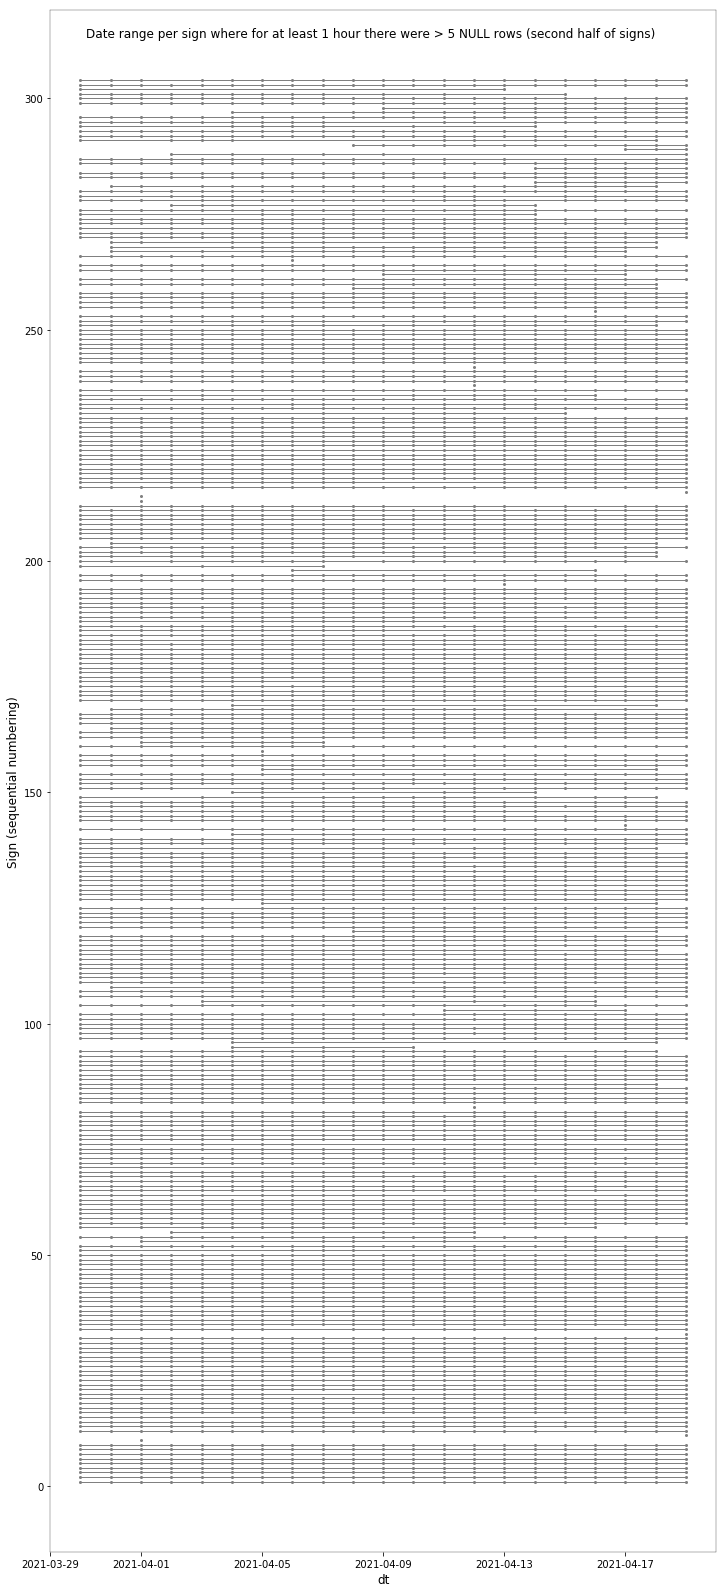

In [177]:
# Second half of all signs

fig, ax =plt.subplots(1)
fig.set_size_inches(10, 22)
ax = plt.gca()

idx=1
for this_id in df_daily['api_id'].unique()[int(num_api/2):]:
    ypos=idx
    idx+=1
    ax.plot(df_daily.loc[df_daily['api_id']==this_id, ['dt']], 
            df_daily.loc[df_daily['api_id']==this_id, ['api_id']].apply(lambda x: x*0+ypos), 
            linewidth=1, color='gray', marker='o', markersize=2)
    
fig.suptitle('Date range per sign where for at least 1 hour there were > 5 NULL rows (second half of signs)', fontsize=12)
fig.tight_layout()

ax.set_ylabel('Sign (sequential numbering)', fontsize=12)
ax.set_xlabel('dt', fontsize=12)

plt.show()

<Figure size 432x288 with 0 Axes>

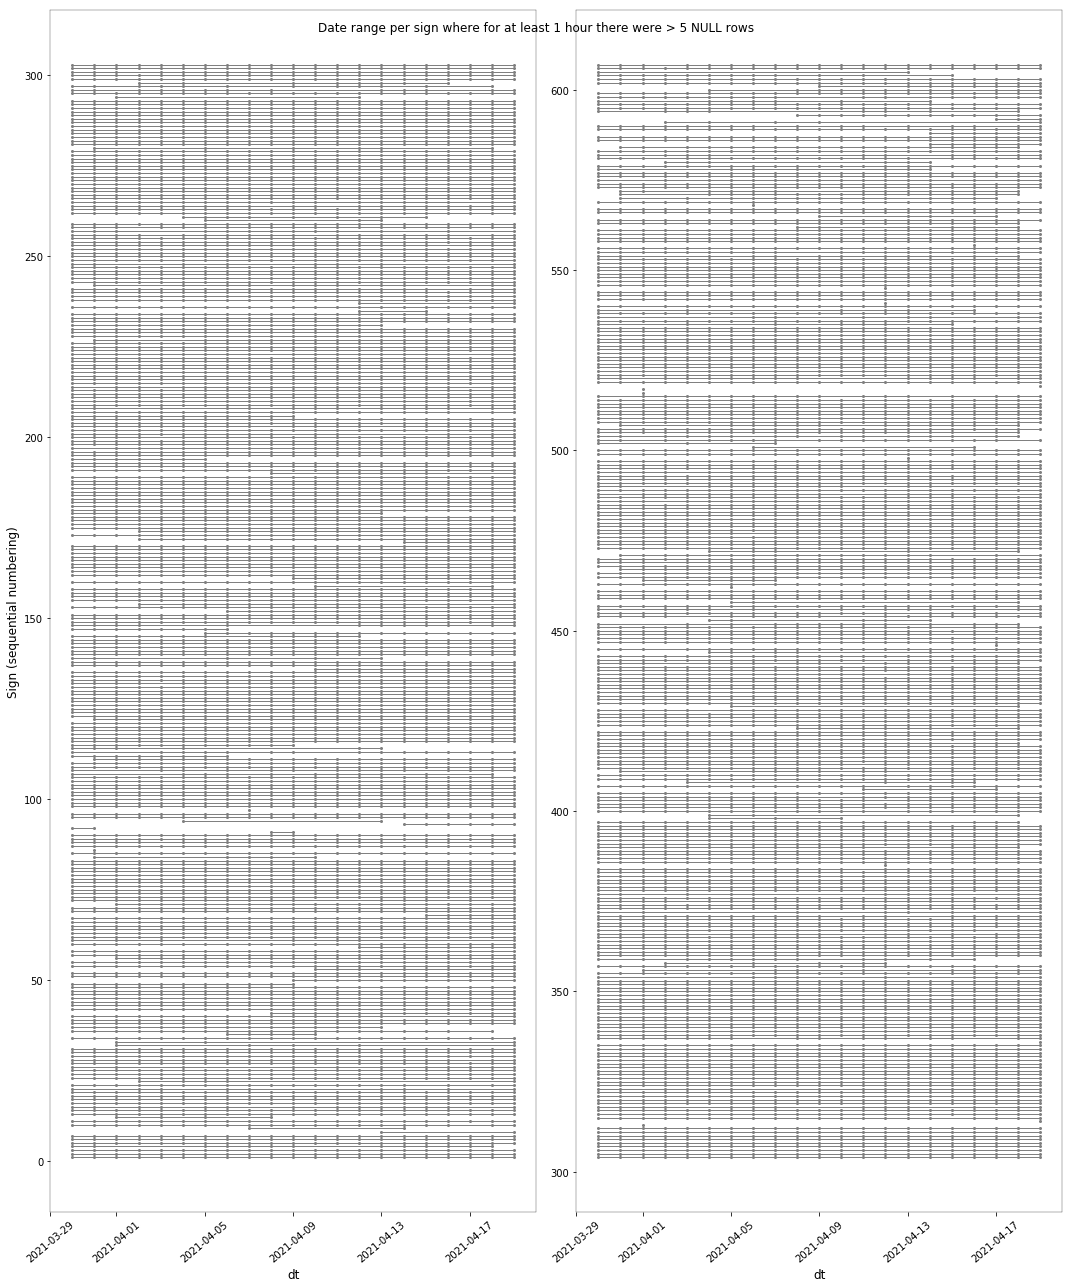

In [179]:
# First (left) and second (right) half of all signs

fig = plt.figure()
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,18))


num_api=len(df_daily['api_id'].unique())

idx=1
for this_id in df_daily['api_id'].unique()[:int(num_api/2)]:
    ypos=idx
    idx+=1
    ax[0].plot(df_daily.loc[df_daily['api_id']==this_id, ['dt']], 
            df_daily.loc[df_daily['api_id']==this_id, ['api_id']].apply(lambda x: x*0+ypos), 
            linewidth=1, color='gray', marker='o', markersize=2)


for this_id in df_daily['api_id'].unique()[int(num_api/2):]:
    ypos=idx
    idx+=1
    ax[1].plot(df_daily.loc[df_daily['api_id']==this_id, ['dt']], 
            df_daily.loc[df_daily['api_id']==this_id, ['api_id']].apply(lambda x: x*0+ypos), 
            linewidth=1, color='gray', marker='o', markersize=2)

fig.suptitle('Date range per sign where for at least 1 hour there were > 5 NULL rows', fontsize=12)
ax[0].tick_params(axis='x', labelrotation=40)
ax[1].tick_params(axis='x', labelrotation=40)


ax[0].set_ylabel('Sign (sequential numbering)', fontsize=12)
ax[0].set_xlabel('dt', fontsize=12)
ax[1].set_xlabel('dt', fontsize=12)

fig.tight_layout()
plt.show()